In [34]:
import numpy as np
from utils import get_and_fit_gp, ModelListGP
import matplotlib.pyplot as plt
from matplotlib import ticker
import pickle
import torch

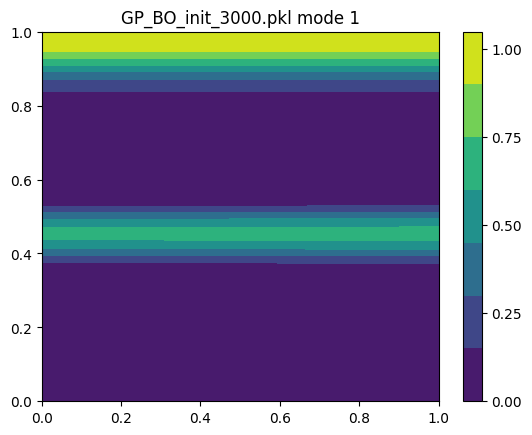

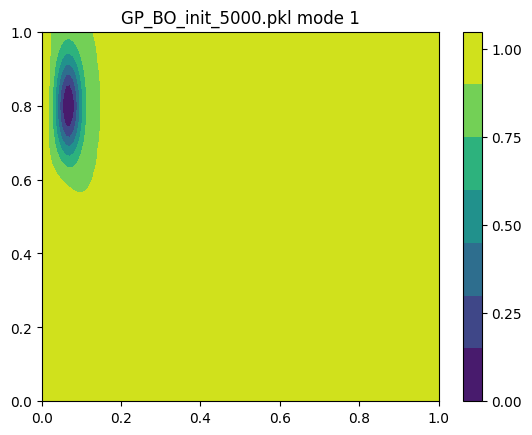

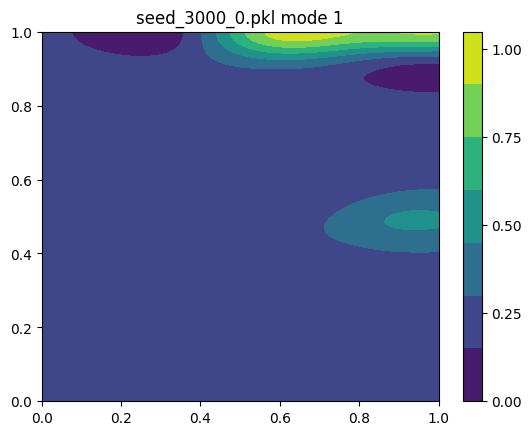

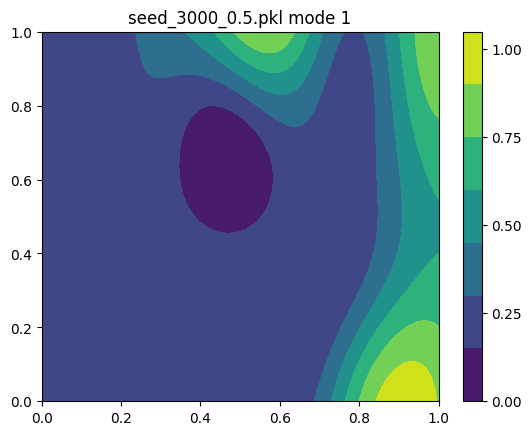

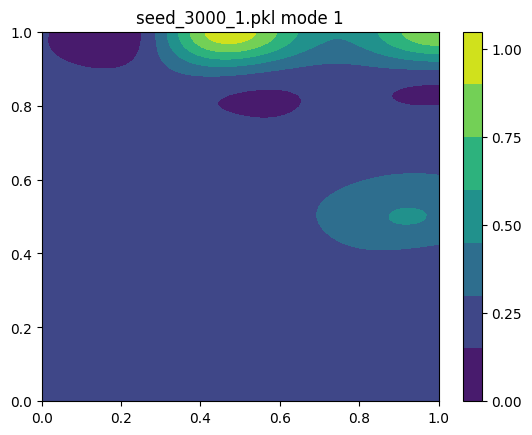

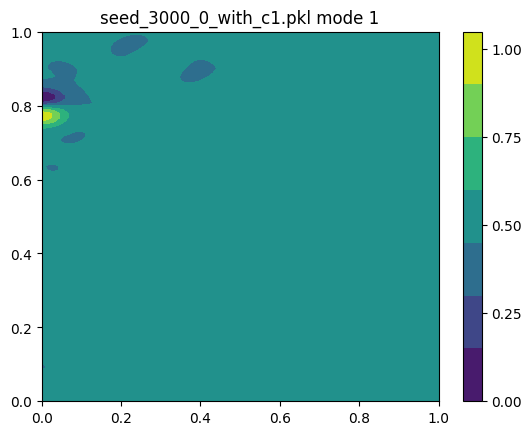

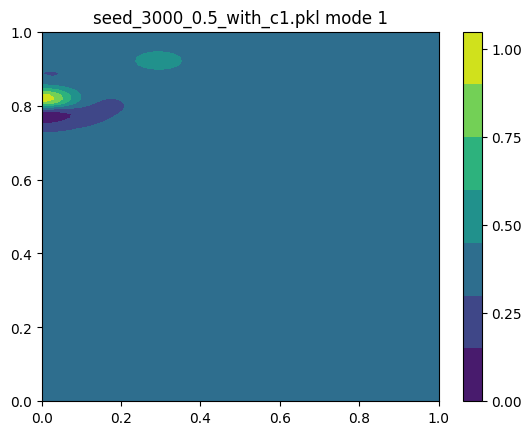

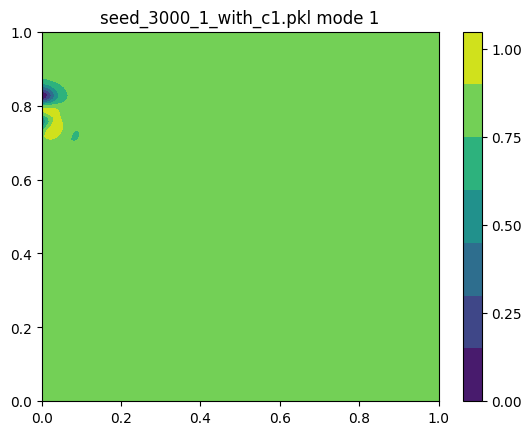

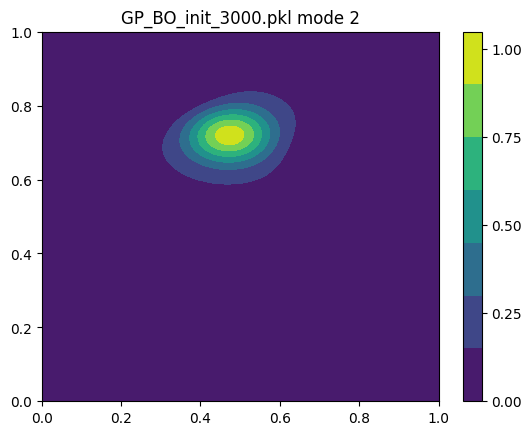

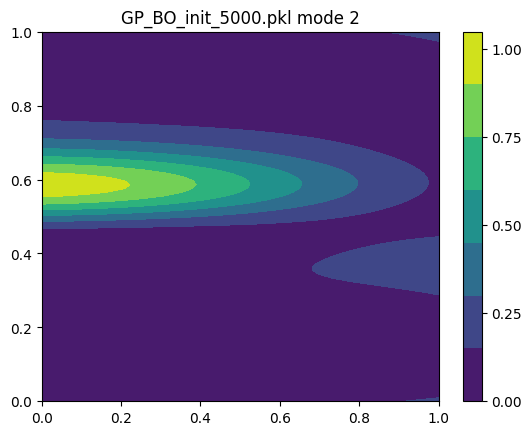

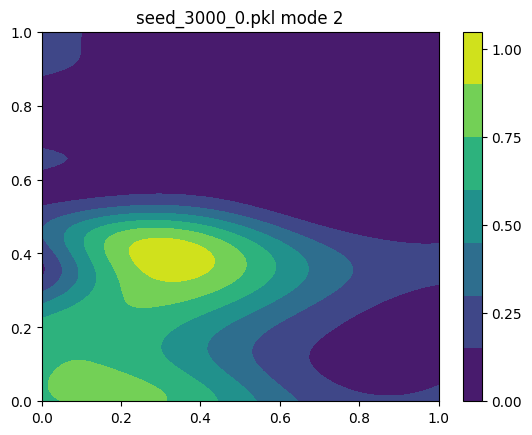

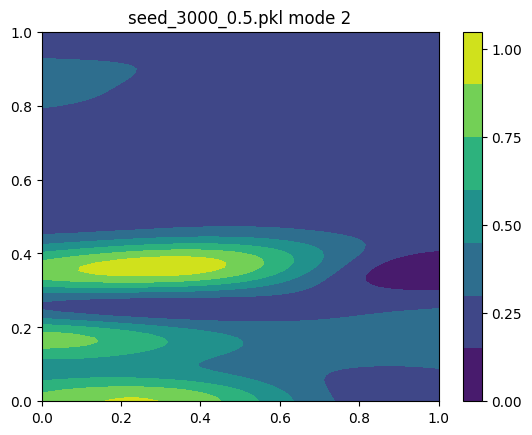

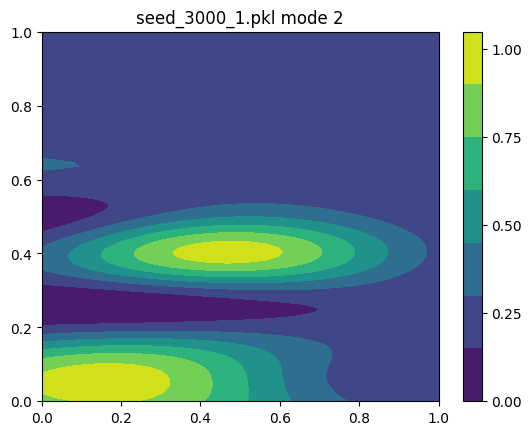

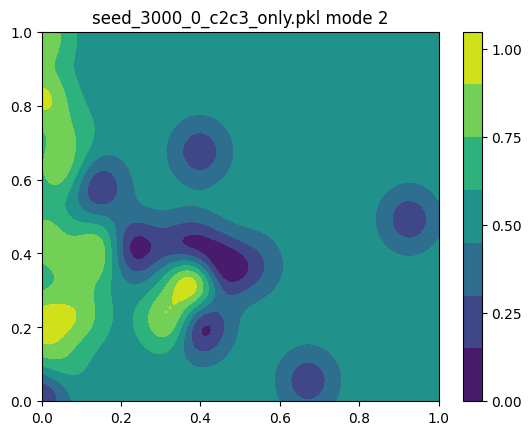

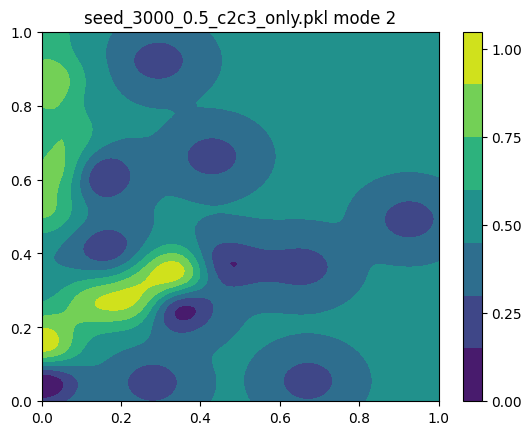

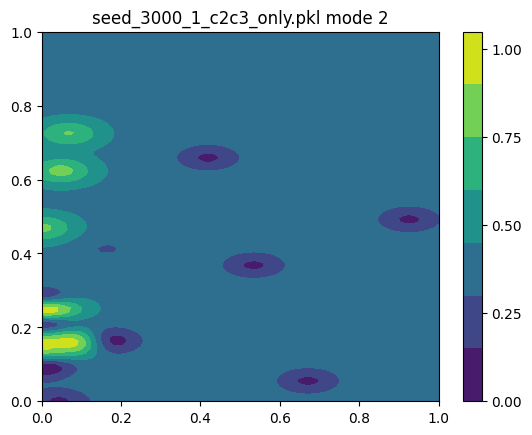

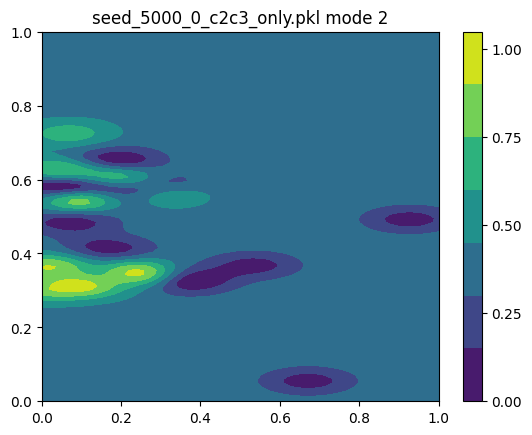

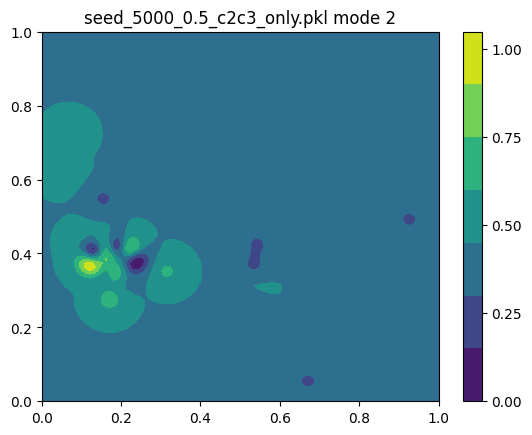

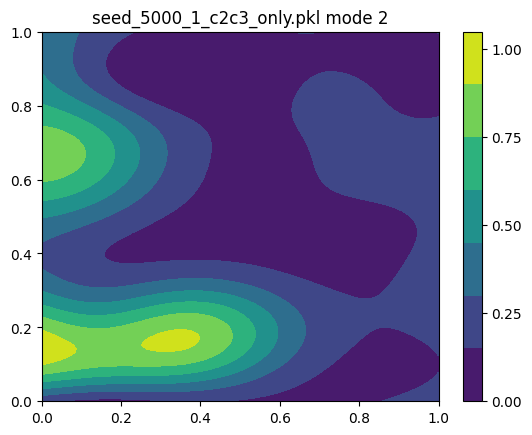

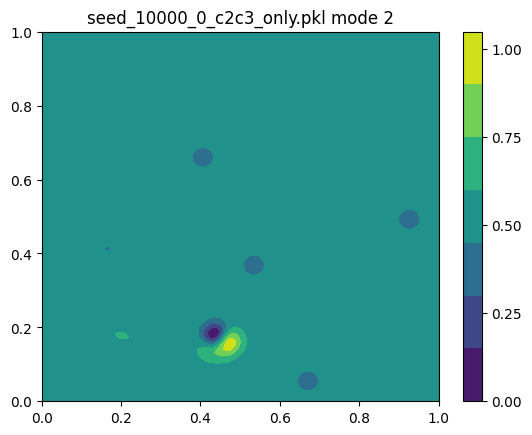

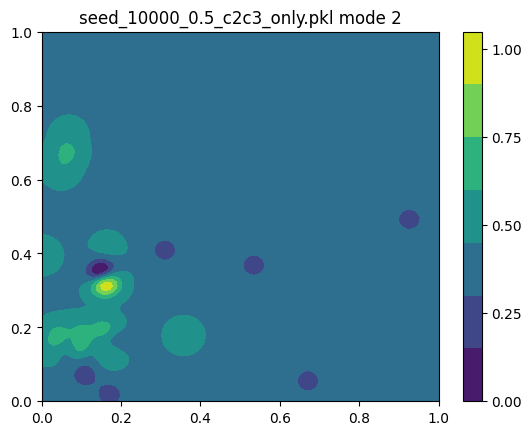

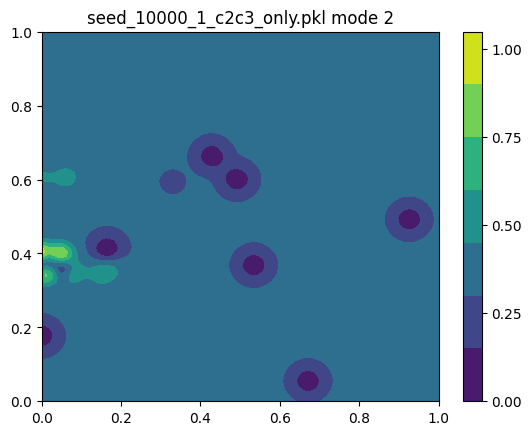

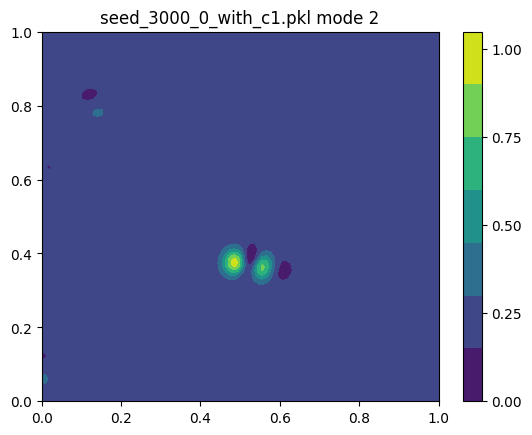

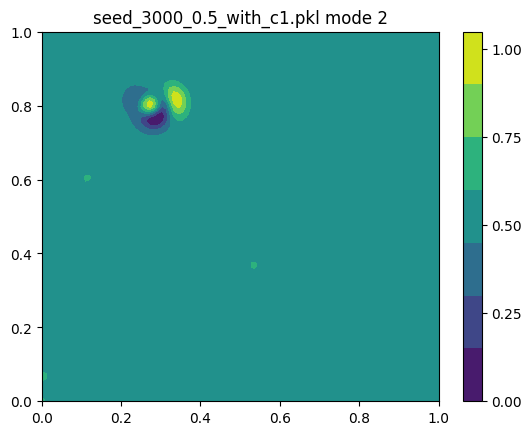

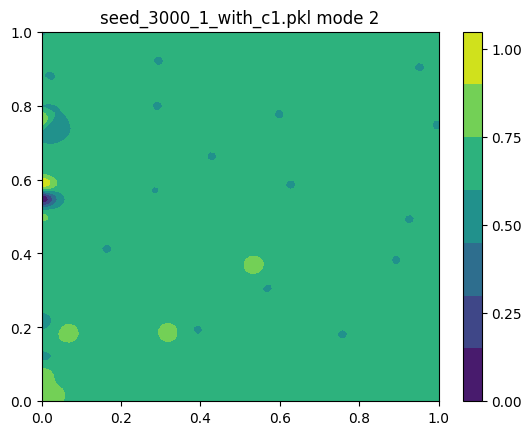

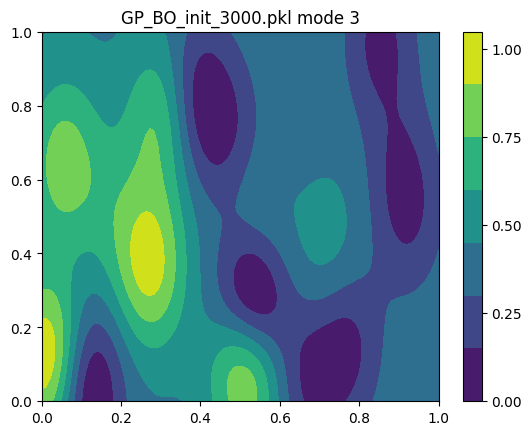

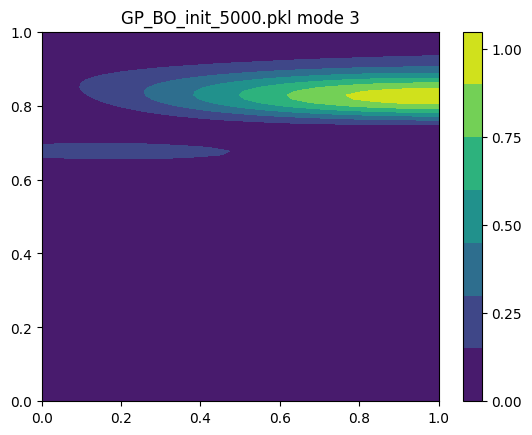

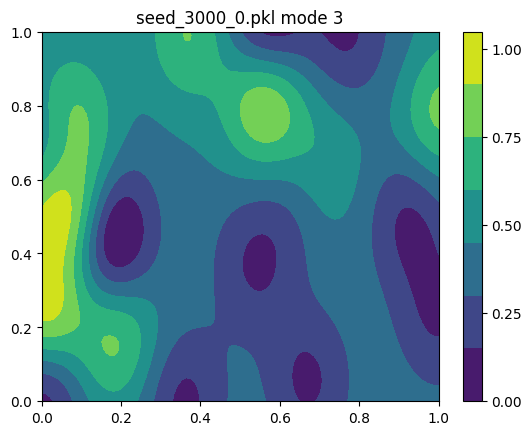

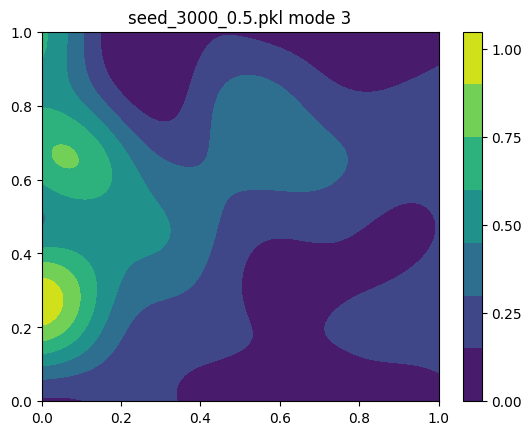

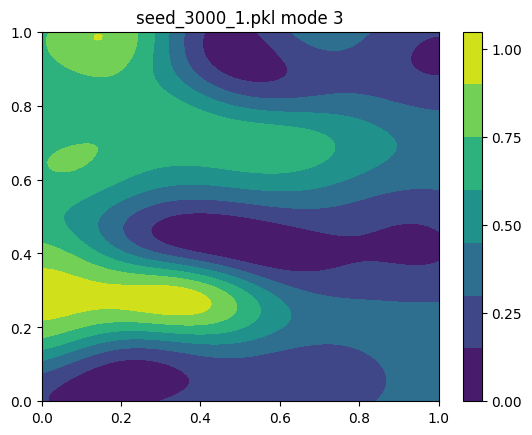

IndexError: list index out of range

In [64]:
N=100   

plt.gca().set_aspect("equal")

def plot_cost_contour(path, mode):

    with open(path, 'rb') as f:
        data = pickle.load(f)

    Y = data['y_data'].double().detach()
    X = data['X'].double().detach() if torch.is_tensor(data['X']) else torch.tensor(data['X'], dtype=torch.float64).detach()
    Y = Y[:len(X),:]
    X = X[:len(Y),:]
    # print(X.size(), Y.size())

    gp_models = [
        get_and_fit_gp(X,  Y[:, i : i + 1].reshape(-1,1)) 
        for i in range(Y.shape[-1])
    ]

    # for im in range(len(gp_models)):
    for im in (mode-1,):

        model = gp_models[im]

        model.eval()
        test_points = []
        test_interval = np.linspace(0, 1, N)

        for i in test_interval:
                for j in test_interval:
                        test_points.append([i, j])

        test_points = torch.tensor(test_points)
        post = model.posterior(test_points.float())
        mean = post.mean.detach().cpu().numpy().reshape((N,N))

        mean = (mean - np.min(mean))/np.ptp(mean) # rescale to 0, 1
        # mean = mean.clip(0,1) # other option

        plt.clf()
        fig = plt.contourf(test_interval,test_interval,mean)
        plt.title(f'{path} mode {int(im+1)}')
        cb = plt.colorbar()

        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()

        plt.show(fig)


types = ('init', 'all', 'c2c3', 'w/c1')

suffixes = {
    'all': "",
    'c2c3': "_c2c3_only",
    'w/c1': "_with_c1"
}

seeds = {
    'init': (3000, 5000),
    'all': (3000,),
    'c2c3': (3000, 5000, 10000),
    'w/c1': (3000,),
}

modes_to_types = {
    1: ('init', 'all', 'w/c1'),
    2: types,
    3: types,
}

lambdas = (0, 0.5, 1)

paths_modes = []
for mode in (1, 2, 3):
    for t in modes_to_types[mode]:
        if t == 'init':
            for seed in seeds[t]:
                paths_modes.append((f'GP_BO_init_{seed}.pkl', mode))
        else:
            for seed in seeds[t]:
                for l in lambdas:
                    paths_modes.append((f'seed_{seed}_{l}{suffixes[t]}.pkl', mode))
# print (paths)

for path, mode in paths_modes:
    plot_cost_contour(path, mode)
